# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import math
import tensorflow as tf
import pickle
import numpy as np
import cv2
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.python.ops.variables import Variable
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm import tqdm
import time
import datetime
import matplotlib.image as mpimg
import os
%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
# training_file = "traffic-signs-data/train.p"
# training_file = open(traffic-signs-data+"/train.p", 'rb')
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
sizes = train['sizes']
coords = train['coords'] 

print("There are totoal items: ", X_train.shape[0])

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_train,
#     y_train,
#     test_size=0.05,
#     random_state=66)


print(X_train.shape)

There are totoal items:  39209
(39209, 32, 32, 3)


In [2]:
### To start off let's do a basic data summary.

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# What's the shape of an image?
image_shape = X_train[0].shape

# How many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

sign_labels = {
  0. : "Speed limit (20km/h)",
  1. : "Speed limit (30km/h)",
  2. : "Speed limit (50km/h)",
  3. : "Speed limit (60km/h)",
  4. : "Speed limit (70km/h)",
  5. : "Speed limit (80km/h)",
  6. : "End of speed limit (80km/h)",
  7. : "Speed limit (100km/h)",
  8. : "Speed limit (120km/h)",
  9. : "No passing",
  10.: "No passing for vehicles over 3.5 metric tons",
  11.: "Right-of-way at the next intersection",
  12.: "Priority road",
  13.: "Yield",
  14.: "Stop",
  15.: "No vehicles",
  16.: "Vehicles over 3.5 metric tons prohibited",
  17.: "No entry",
  18.: "General caution",
  19.: "Dangerous curve to the left",
  20.: "Dangerous curve to the right",
  21.: "Double curve",
  22.: "Bumpy road",
  23.: "Slippery road",
  24.: "Road narrows on the right",
  25.: "Road work",
  26.: "Traffic signals",
  27.: "Pedestrians",
  28.: "Children crossing",
  29.: "Bicycles crossing",
  30.: "Beware of ice/snow",
  31.: "Wild animals crossing",
  32.: "End of all speed and passing limits",
  33.: "Turn right ahead",
  34.: "Turn left ahead",
  35.: "Ahead only",
  36.: "Go straight or right",
  37.: "Go straight or left",
  38.: "Keep right",
  39.: "Keep left",
  40.: "Roundabout mandatory",
  41.: "End of no passing",
  42.: "End of no passing by vehicles over 3.5 metric tons"
}


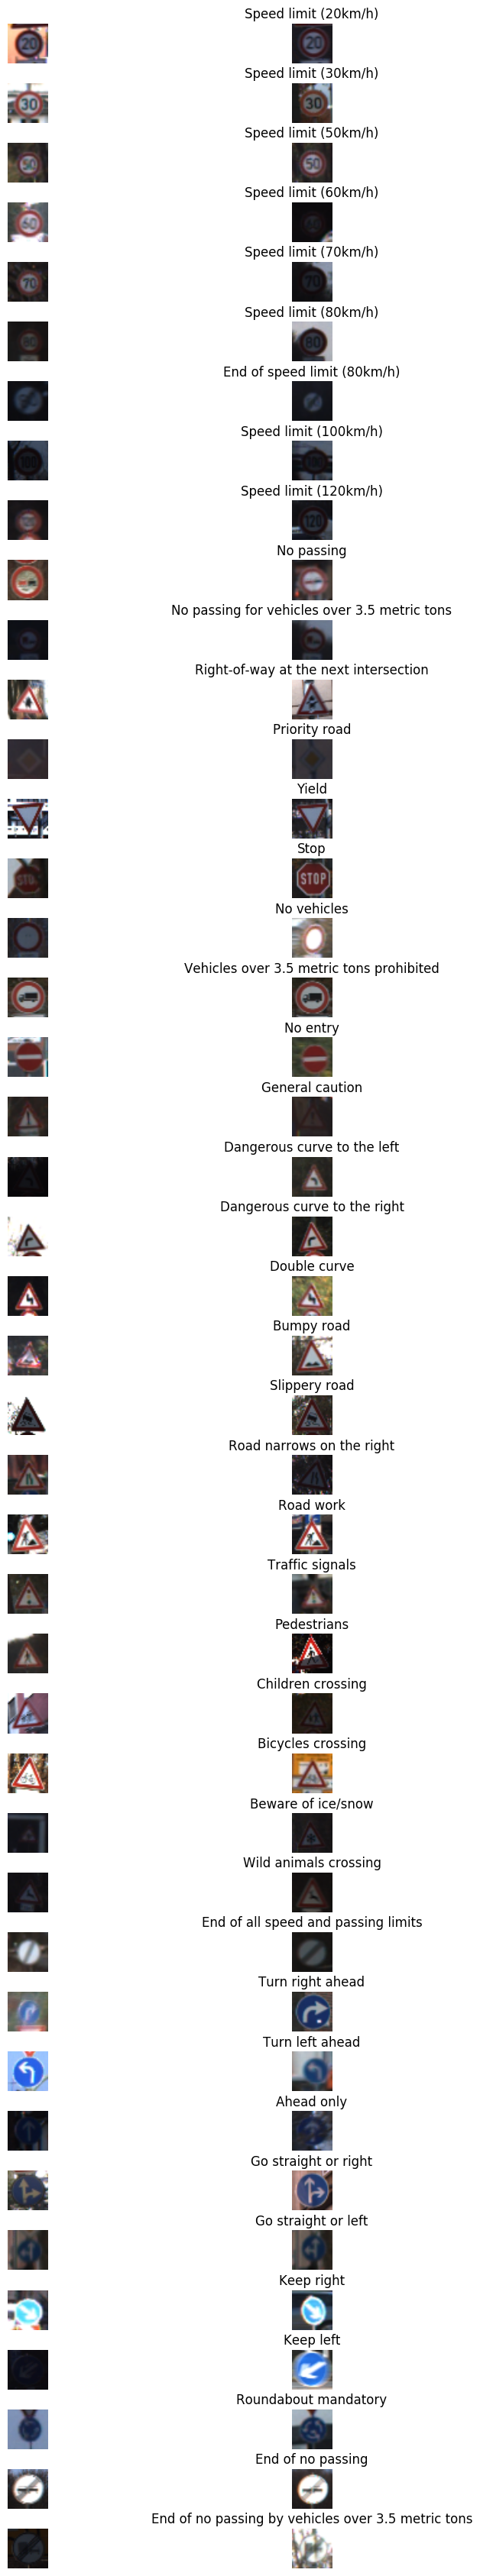

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
sample_size = 2 #four images per class label
n_labels = 43
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size*3, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=3, hspace=0.5)
for i in range(n_labels):
    ind = y_test == i
    subset_x = X_test[ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        if x == 1:
            ax.set_title(sign_labels[i])
        ax.imshow(img, cmap='gray')
        fig.add_subplot(ax) 
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data. Step 1 (Question 1)
### Feel free to use as many code cells as needed.

# Convert image to grayscale 

def pre_process_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=4)
    # max = 255 (RGB) && deviation = 0.5 make it normalized at[-0.5:0.5] which is even better than [0:1]
    # return image.flatten()/255 - 0.5
    return image/255 - 0.5

X_train_normalized = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))],
                          dtype = np.float32)
X_test_normalized = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))],
                          dtype = np.float32)

print(X_train.shape)
print(X_train_normalized.shape)
print(X_test_normalized.shape)

(39209, 32, 32, 3)
(39209, 32, 32, 1)
(12630, 32, 32, 1)


### Question 1 

_Describe the techniques used to preprocess the data._

Answer: image/255 makes it [0:1], and I think normalized at[-0.5:0.5] is even better than [0:1]

In [ ]:
### Generate data additional (if you want to!) Step 2 (Question 2)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
### Randomize data

# X_train_features, X_valid_features, y_train_labels, y_valid_labels = train_test_split(
#     X_train_normalized,
#     y_train,
#     test_size = 0.01,
#     random_state = 111)

# print ('Training features and labels randomized and split')
# print (X_train_features.shape)
# print (y_train_labels.shape)
# print (X_valid_features.shape)
# print (y_valid_labels.shape)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

Answer: Didn't split the data in valid. Since the result looks ok to not have it.

In [6]:

# Create hidden layer, Conv2D wrapper, with bias, max_pooling, dropout and relu activation
def new_conv_layer(inputs, filter, biases, strides=1, padding='SAME', use_pooling=True, use_dropout=False):
    # Convolute input with filter
    layer = tf.nn.conv2d(inputs, filter, strides=[1,strides,strides,1], padding=padding)
    # Add bias
    layer = tf.nn.bias_add(layer, biases)
    # Use max pooling if requested
    if use_pooling:
        layer = max_pool(layer)
        
#     if use_dropout:
#         layer = tf.nn.dropout(layer, 0.5)

    # Apply activation function
    return tf.nn.relu(layer)

# Down-sample the given layer with the given filter size, based on example of Lecture 30 in CNN.
def max_pool(layer, filter_size=2, padding='SAME'):
    return tf.nn.max_pool(layer, ksize=[1,filter_size,filter_size,1], strides=[1,filter_size,filter_size,1], padding=padding)

def flatten(layer):
    # Shape of the input layer assumed to be [num_images, img_height, img_width, num_channels]
    shape = layer.get_shape()
    # Number of featurs is img_height * img_width * num_channels
    num_features = shape[1:4].num_elements()

# Create model
def model(inputs, weights, biases):
    layer1 = new_conv_layer(inputs, weights['layer_1'], biases['layer_1'])
    layer2 = new_conv_layer(layer1, weights['layer_2'], biases['layer_2'])
    layer3 = new_conv_layer(layer2, weights['layer_3'], biases['layer_3'])
    # We will add fully-connected layers after the convolution layers, 
    # so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.
    fully_connected_layer = tf.reshape(layer3, [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fully_connected_layer = tf.add(tf.matmul(fully_connected_layer, weights['fully_connected']), biases['fully_connected'])
    fully_connected_layer = tf.nn.relu(fully_connected_layer)
    model = tf.add(tf.matmul(fully_connected_layer, weights['out']), biases['out'])
    return model

def loss(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

def one_hot(y, n_classes):
    y_one_hot = tf.one_hot(y, n_classes, dtype=np.float32)
    return y_one_hot.eval()

# def one_hot(Y_tr,n_classes):
#     OHC = OneHotEncoder()
#     Y_ohc = OHC.fit(np.arange(n_classes).reshape(-1, 1))
#     Y_labels = Y_ohc.transform(Y_tr.reshape(-1, 1)).toarray()
#     Y_labels = Y_labels.astype(np.float32)
#     return Y_labels

In [7]:
# Parameters
learning_rate = 0.001
batch_size = 128
training_epochs = 200

image_height = image_width = image_shape[0]

# Width of each hidden layer in the model
layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

# Declare a weights tensor and initialize with random normally distributed values
# stddev needs to be smaller instead of default 1.0 is key. Need to find the reason.
dev=0.05

# Size of filter applied in convolution
# Only single dimension provided as filters are typically square shaped
filter_size = 5

# Number of color channels in the image. We convert all images to grayscale, so only one channel for 1st layer
color_channels = 1

# Assign weights for each layer in the model
weights = { 
  'layer_1' : tf.Variable(tf.truncated_normal(
            [filter_size, filter_size, color_channels, layer_width['layer_1']],stddev=dev)),
  'layer_2' : tf.Variable(tf.truncated_normal(
            [filter_size, filter_size, layer_width['layer_1'], layer_width['layer_2']],stddev=dev)),
  'layer_3' : tf.Variable(tf.truncated_normal(
            [filter_size, filter_size, layer_width['layer_2'], layer_width['layer_3']],stddev=dev)),
  'fully_connected' : tf.Variable(tf.truncated_normal(
            [4*4*128, layer_width['fully_connected']],stddev=dev)),
  'out' : tf.Variable(tf.truncated_normal(
            [layer_width['fully_connected'], n_classes],stddev=dev))
}

# Instead of all 0, give some initial value.
def initial_biases(length, value=0.05):
    return tf.Variable(tf.constant(value, shape=[length]))

# Assign biases for each layer of the model
biases = {
  'layer_1' : initial_biases(layer_width['layer_1']),
  'layer_2' : initial_biases(layer_width['layer_2']),
  'layer_3' : initial_biases(layer_width['layer_3']),
  'fully_connected' : initial_biases(layer_width['fully_connected']),
  'out' : initial_biases(n_classes)
}

# Input images
x = tf.placeholder(tf.float32, [None, image_width, image_height, color_channels], name='x')

# Input labels
y = tf.placeholder(tf.float32, [None, n_classes])

# Predictions
logits = model(x, weights, biases)

# Determine the loss value
cost = loss(logits, y)

# Define the optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


Answer: 
The reason of putting small deviation on the weights is for the gradients to be well behaved. If you initialize weights too large, they will either be in flat part of relu or in linear part. So you get scenenario where you get graident going to 0 or infinity.

Somehow, my dropout will trigger huge cost increase in several iterations. Didn't use it for now.

The variable numbers are pretty much based on the lecture30 in Convolutional Neural Networks.

I also refer to the structure from Danilo Unite and some code based on the Hvass Laboratories from youtube.

In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.

def random_batch(images, labels, batch_size):
    # Number of images in the training-set.
    num_images = len(images)

    # Create a random index.
    idx = np.random.choice(num_images, size=batch_size, replace=False)

    # Use the random index to select random images and labels.
    # 
    if(len(images) == 4): # Color channel
        features_batch = images[idx, :,:,:]
    else: # Grayscale
        features_batch = images[idx, :,:]
    labels_batch = labels[idx, :]

    return features_batch, labels_batch

# Initialize the variables
init = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    total_batches = int(round(n_train/batch_size))

    # One-hot encode labels for classifier
    one_hot_y_train = one_hot(y_train, n_classes)
    one_hot_y_test = one_hot(y_test, n_classes)

    batch_count = int(n_train)

    # Keep track of how long the optimization takes
    import time
    start = time.time()

    # Perform optimization over several epochs to improve model accuracy
    # Optimization is done when all epochs are complete or when the
    # cost has gone down to a small epsilon value
    epsilon = 0.000000001
    for epoch in range(training_epochs):
      # Loop over all batches
      for i in range(total_batches):
        batch_x, batch_y = random_batch(X_train_normalized, one_hot_y_train, batch_size)

        # Run optimization operation (backprop) and cost operation (to get loss value)
        feed = {x: batch_x, y: batch_y}
        sess.run(optimizer, feed_dict=feed)

      # Display logs per epoch step
      c = sess.run(cost, feed_dict=feed)
      if math.isnan(c):
        print("Epoch:", '%10d' % (epoch+1), "cost=", c)
      else:
        expected = tf.argmax(y,1)
        correct_prediction = tf.equal(tf.argmax(logits, 1), expected)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, np.float32))
        a = accuracy.eval({x: batch_x, y: batch_y})
        print("Epoch:", '%10d' % (epoch+1), "  Cost:", "{:.9f}".format(c), "  Accuracy:", "{:.9f}".format(a))
  
      if c < epsilon:
        break

    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)

    # Display amount of time for training
    print("\n")
    print("Optimization finished in:")
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
    print("\n")

    # Evaluate and display model predictions on last training batch
    predictions = tf.argmax(logits,1)
    print("Final training batch predictions:", predictions.eval({x: batch_x}))
    print("\n")

    # Display expected values on last training batch
    expected = tf.argmax(y,1)
    print("Final training batch expected values:", expected.eval({y: batch_y}))
    print("\n")

    # Display true and false model predictions on final training batch
    correct_prediction = tf.equal(tf.argmax(logits, 1), expected)
    print("Correct predictions:", correct_prediction.eval({x: batch_x, y: batch_y}))
    print("\n")

    # Calculate and display model accuracy on final training batch
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, np.float32))
    print("Accuracy on final training batch:", accuracy.eval({x: batch_x, y: batch_y}))
    print("\n")

    # Calculate accuracy of trained model on test data (i.e. not in training set)
    print("Accuracy on test data:", accuracy.eval({x: X_test_normalized, y: one_hot_y_test}))

    # Display trainable variables before saving state
    print("Before save....")
    all_vars = tf.trainable_variables()
    for v in all_vars:
      print(v.name)

    # Save the variables state for later sessions
    save_path = saver.save(sess, "trained-model-py.ckpt")

Epoch:          1   Cost: 0.166507170   Accuracy: 0.960937500
Epoch:          2   Cost: 0.052952431   Accuracy: 0.984375000
Epoch:          3   Cost: 0.028587375   Accuracy: 1.000000000
Epoch:          4   Cost: 0.040611394   Accuracy: 0.992187500
Epoch:          5   Cost: 0.013203787   Accuracy: 1.000000000
Epoch:          6   Cost: 0.006225280   Accuracy: 1.000000000
Epoch:          7   Cost: 0.002301033   Accuracy: 1.000000000
Epoch:          8   Cost: 0.006173862   Accuracy: 1.000000000
Epoch:          9   Cost: 0.001619790   Accuracy: 1.000000000
Epoch:         10   Cost: 0.005607564   Accuracy: 1.000000000
Epoch:         11   Cost: 0.003084633   Accuracy: 1.000000000
Epoch:         12   Cost: 0.001683825   Accuracy: 1.000000000
Epoch:         13   Cost: 0.000388725   Accuracy: 1.000000000
Epoch:         14   Cost: 0.002054045   Accuracy: 1.000000000
Epoch:         15   Cost: 0.000809827   Accuracy: 1.000000000
Epoch:         16   Cost: 0.000193011   Accuracy: 1.000000000
Epoch:  

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


Answer: 
Since our original image is 32x32, and we used max-pooling to drop half of the size. The resonable number of Layers I think is 3. 
Original image: batch_sizeX32X32X3
Layer 1: batch_sizeX32X32X32
L1 after maxpool: batch_sizeX16X16X32
Layer 2: batch_sizeX16X16X64
L2 after maxpool: batch_sizeX8X8X64
Layer 3: batch_sizeX8X8X128
L3 after maxpool: batch_sizeX4X4X128
FC: batch_sizeX2048 (batch_sizeX4 X 4 X 128)

I start with batch size of 20 with 100 training epochs and very large 0.1 learning rate, which was used when I use simple linear model to complete Project2 with 89% accuracy. When my cost was not decrease sharply like others in the class. So, I increase my batch size, eventually to 128, and once I have relatively good cost and reasonable starting accuracy, I lower my learning rate to 0.001.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

Answer:
Initially, I was kind of lost of how to start this project. My mentor Sam sent me the youtube video of the Hvass Laboratories, the second tutorial of Convolutional Neural Network is very helpful. It clears lots of ideas.
And also the extra lectures that was put in the Convolutional Neural Network is very helpful as well, I decide to use that code templet for this project. Some details that I need to ask some expert like Vivek Yadav from Slack and my mentor Sam. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

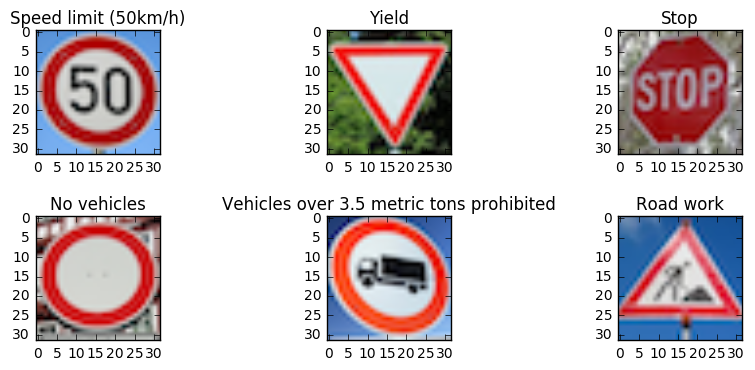

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

test_dir_name = "test_images"
filenames = ["SPEED50_2.png", "YIELD_13.png", "STOP_14.png", "NO_VEHICLES_15.png", "NO3.5_16.png", "ROADWORK_25.png"]

test_images = [mpimg.imread(test_dir_name + "/" + file) for file in filenames]

new_labels = np.array([2, 13, 14, 15, 16, 25], np.uint8)

def plot_images(images, rows, columns, labels=[], labels_dict={}):
    figure = plt.figure()
    figure.subplots_adjust(right=1.5, hspace=0.5)
    n_images = len(images)
    max_plots = rows * columns
    end_range = n_images + 1 if n_images < max_plots else max_plots + 1
    for i in range(1,end_range):
        idx = np.random.choice(n_images, size=1, replace=False)[0] if random == True else i-1
        image = images[idx]
        subplot = figure.add_subplot(rows,columns,i)
        if len(labels) == n_images:
            id = labels[idx]
            label = labels_dict[id]
        else:
            label = ""
        subplot.set_title(label)
        plt.imshow(image)
    plt.show()
    
plot_images(test_images,rows=2,columns=3,labels=new_labels,labels_dict=sign_labels)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [40]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph('trained-model-py.ckpt.meta')
#     new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    saver.restore(sess, "trained-model-py.ckpt")
    
    one_hot_new_labels = one_hot(new_labels, n_classes)
    new_images_normalized = np.array([pre_process_image(test_images[i]) for i in range(len(test_images))], dtype = np.float32)

    # Calculate accuracy of trained model on new data (i.e. not in training or test set)
    print("Accuracy on new data:", accuracy.eval({x: new_images_normalized, y: one_hot_new_labels}))

    # Save the model for later sessions
#     save_path = saver.save(sess, "trained-model-py.ckpt")

Accuracy on new data: 0.0


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


Answer: Fail.

probabilities:
[[  5.45719326e-01   4.48566407e-01   2.85312673e-03   2.20435648e-03
    2.72616948e-04]
 [  9.02942717e-01   9.00155082e-02   3.48593621e-03   3.15748341e-03
    1.79934301e-04]
 [  7.77729630e-01   2.14274600e-01   5.14261145e-03   2.44417461e-03
    1.62177952e-04]
 [  7.01005340e-01   2.93628395e-01   2.81490176e-03   2.14497675e-03
    1.53742061e-04]
 [  6.59353554e-01   3.35695684e-01   3.04089510e-03   1.34952553e-03
    2.88889685e-04]
 [  6.13506734e-01   3.80984128e-01   3.12661403e-03   2.00379896e-03
    1.52502354e-04]]
class ids:
[[ 3 18 13  5 38]
 [ 3 18  5 13 38]
 [ 3 18 13  5 38]
 [ 3 18 13  5  9]
 [ 3 18  5 13 38]
 [ 3 18 13  5 38]]


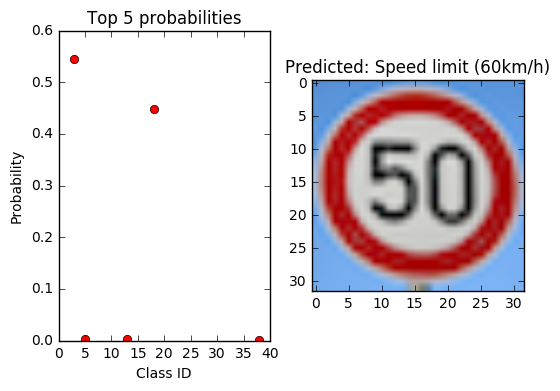

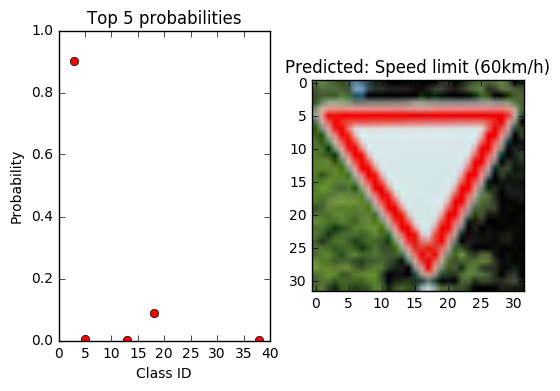

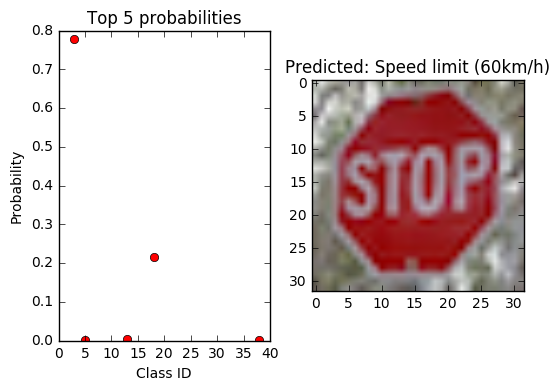

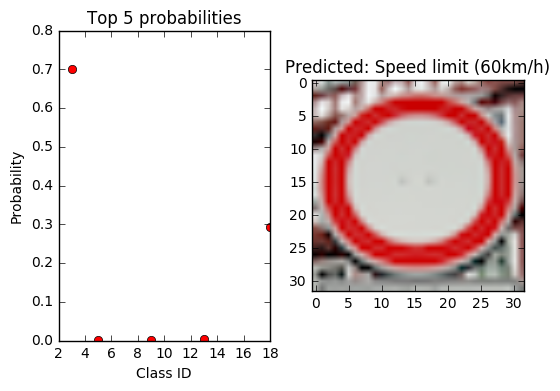

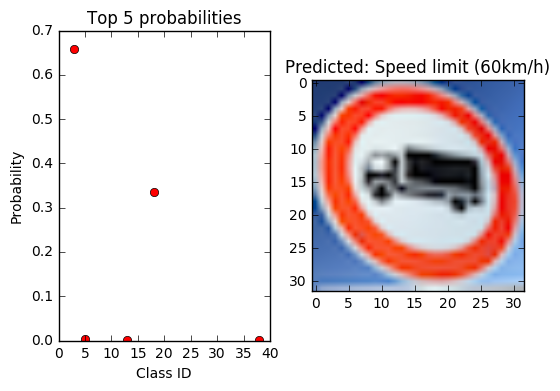

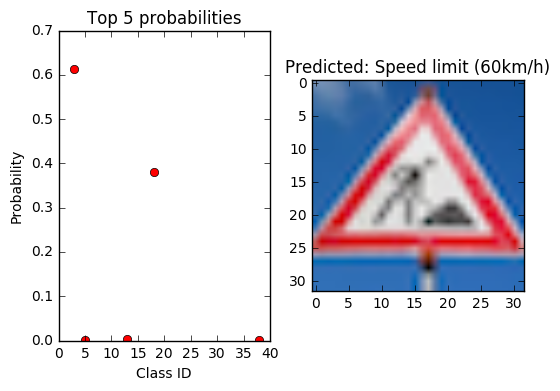

In [42]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def plot_probability_per_class(probabilities, classes, image):
    figure = plt.figure()

    subplot = figure.add_subplot(1,2,1)
    subplot.set_title('Top 5 probabilities')
    plt.plot(classes, probabilities, 'ro')  
    plt.ylabel('Probability')
    plt.xlabel('Class ID')

    top = probabilities.argmax()
    class_id = classes[top]
    predicted = sign_labels[float(class_id)]
  
    subplot = figure.add_subplot(1,2,2)
    title = "Predicted: %s" % predicted
    subplot.set_title(title)
    plt.imshow(image)

    plt.show()

with tf.Session() as sess:
#     new_saver = tf.train.import_meta_graph('trained-model-py.ckpt.meta')
#     new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    saver.restore(sess, "trained-model-py.ckpt")
    
    new_softmax_predictions = tf.nn.softmax(logits)
    topFive = tf.nn.top_k(new_softmax_predictions, k=5, sorted=True, name=None)
    
    print("probabilities:")
    probabilities = topFive.values.eval({x: new_images_normalized}, session=sess)
    print(probabilities)
    
    print("class ids:")
    classes = topFive.indices.eval({x: new_images_normalized}, session=sess)
    print(classes)
    
    for p, c, i in zip(probabilities, classes, test_images):
        plot_probability_per_class(p, c, i)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


Answer: Actually the first image kind of make sense, because it predict it as Speed limit 60, "5" is kind of like "6"... But somehow, all others are just way off. I noticed that all the prediction are Speed limit 60, which makes think whether there is some bug in my model.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.